In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras.layers as tfl
import os
import cv2 as cv
import scipy
import imageio
import matplotlib.pyplot as plt

In [27]:
ROOT_DIR = os.path.abspath("D:\Kaggle\SemanticSegmentataion")
mask_path = os.path.join(ROOT_DIR, r"CameraMask\\")
camera_img = os.path.join(ROOT_DIR, r"CameraRGB\\")
f_dir = os.listdir(mask_path)
# print(len(f_dir))
img_list = [camera_img + i for i in f_dir]
mask_list = [mask_path + i for i in f_dir]

In [28]:
print(mask_list[2])

D:\Kaggle\SemanticSegmentataion\CameraMask\\000028.png


In [33]:
image = []
mask = []

for img in img_list:
    file = tf.io.read_file(img)
    im = tf.image.decode_png(file, channels = 3)
    im = tf.image.convert_image_dtype(im, tf.float32)
    im = tf.image.resize(im, (128, 128))
    image.append(im)

for msk in mask_list:
    file = tf.io.read_file(msk)
    mk = tf.image.decode_png(file, channels = 3)
    mk = tf.math.reduce_max(mk, axis=-1, keepdims=True)
    mk = tf.image.resize(mk, (128, 128), method='nearest')
    mask.append(mk)

In [34]:
train_x = tf.data.Dataset.from_tensor_slices(image)


# train_y_cat = keras.utils.to_categorical(mask, num_classes = 23)
train_y = tf.data.Dataset.from_tensor_slices(mask)

train = tf.data.Dataset.zip((train_x, train_y))

BATCH = 128
AT = tf.data.AUTOTUNE
BUFFER = 500

train2 = train.cache().shuffle(BUFFER).batch(BATCH)
train2 = train.prefetch(buffer_size=AT)

C:\Users\s9554\AppData\Local\Temp\ipykernel_7900\2979581932.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[2])
C:\Users\s9554\AppData\Local\Temp\ipykernel_7900\2979581932.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_list[2])


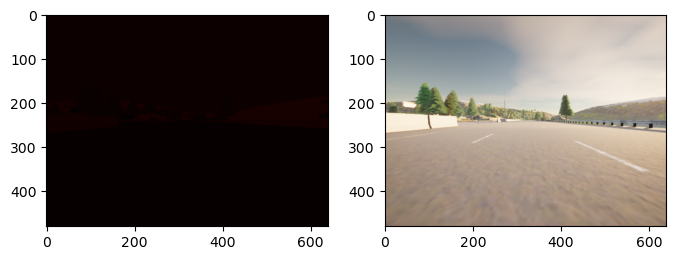

In [6]:
mask = imageio.imread(mask_list[2])
img = imageio.imread(img_list[2])
fig, ax = plt.subplots(1, 2, figsize = (8, 5))
ax[0].imshow(mask)
ax[1].imshow(img)

In [7]:
def conv_block(input, filters, dropout_prob = 0, max_pooling = True):
    conv = tfl.Conv2D(filters = filters, kernel_size = 3, activation =  "relu", padding = "same", kernel_initializer = "he_normal")(input)
    conv2 = tfl.Conv2D(filters = filters, kernel_size = 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv)
    
    if dropout_prob > 0:
        conv3 = tfl.Dropout(dropout_prob)(conv2)
    if max_pooling:
        next_layer = tfl.MaxPooling2D(2,strides=2)(conv2)
    else:
        next_layer = conv2
        
    skip_connection = conv2
    return skip_connection, next_layer

In [8]:
def upsampling(concate_input, upsample_input, filters):
    up = tfl.Conv2DTranspose(filters = filters, kernel_size = 3, strides = 2, padding = "same")(upsample_input)
    merge = tfl.concatenate([up, concate_input], axis=3)
    conv = tfl.Conv2D(filters = filters, kernel_size = 3, activation =  "relu", padding = "same", kernel_initializer = "he_normal")(merge)
    conv2 = tfl.Conv2D(filters = filters, kernel_size = 3, activation =  "relu", padding = "same", kernel_initializer = "he_normal")(conv)

    return conv

In [9]:
def UNet(input_size = (128, 128, 3), filters = 32, n_class = 23):
    inputs = keras.Input((input_size))

    cblock1 = conv_block(input = inputs, filters=filters * 1)
    cblock2 = conv_block(input = cblock1[1], filters=filters * 2)
    cblock3 = conv_block(input = cblock2[1], filters=filters * 4)
    cblock4 = conv_block(input = cblock3[1], filters=filters * 8)
    cblock5 = conv_block(input = cblock4[1], filters=filters * 16, dropout_prob=0.3, max_pooling=False)

    ublock1 = upsampling(cblock4[0], cblock5[1], filters * 8)
    ublock2 = upsampling(cblock3[0], ublock1, filters * 4)
    ublock3 = upsampling(cblock2[0], ublock2, filters * 2)
    ublock4 = upsampling(cblock1[0], ublock3, filters * 1)

    conv9 = tfl.Conv2D(filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock4)
    conv10 = tfl.Conv2D(n_class, 1, activation = "sigmoid", padding = "same")(conv9)

    return keras.Model(inputs = inputs, outputs = conv10)

In [10]:
UnetModel = UNet()
UnetModel.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                         

In [11]:
UnetModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [12]:
his = UnetModel.fit(train, epochs = 5)

Epoch 1/5


9/9 [==============================] - 61s 6s/step - loss: 2.5536 - accuracy: 0.2751
Epoch 2/5
9/9 [==============================] - 55s 6s/step - loss: 1.7261 - accuracy: 0.4587
Epoch 3/5
9/9 [==============================] - 51s 6s/step - loss: 1.1947 - accuracy: 0.7124
Epoch 4/5
9/9 [==============================] - 50s 6s/step - loss: 0.9693 - accuracy: 0.7730
Epoch 5/5
9/9 [==============================] - 53s 6s/step - loss: 0.7699 - accuracy: 0.8083


In [35]:
UnetModel.save("unet.h5")
unet = keras.models.load_model("unet.h5")

C:\Users\s9554\miniconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [41]:
for image, label in tarin.take(1):
    print(image.shape)

(1, 128, 128, 3)


In [44]:
pre = unet.predict(tarin)
print(pre.shape)
pred_mask = tf.argmax(pre, axis=-1)
pred_mask = pred_mask[..., tf.newaxis]
print(pred_mask.shape)
print(pred_mask)

1060/1060 [==============================] - 37s 35ms/step
(1060, 128, 128, 23)
(1060, 128, 128, 1)
tf.Tensor(
[[[[13]
   [13]
   [13]
   ...
   [13]
   [13]
   [13]]

  [[13]
   [13]
   [13]
   ...
   [13]
   [13]
   [13]]

  [[13]
   [13]
   [13]
   ...
   [13]
   [13]
   [ 1]]

  ...

  [[ 7]
   [ 7]
   [ 7]
   ...
   [ 7]
   [ 7]
   [ 7]]

  [[ 7]
   [ 7]
   [ 7]
   ...
   [ 7]
   [ 7]
   [ 7]]

  [[ 7]
   [ 7]
   [ 7]
   ...
   [ 7]
   [ 7]
   [11]]]


 [[[13]
   [13]
   [13]
   ...
   [13]
   [13]
   [13]]

  [[13]
   [13]
   [13]
   ...
   [13]
   [13]
   [13]]

  [[13]
   [13]
   [13]
   ...
   [13]
   [13]
   [ 1]]

  ...

  [[ 7]
   [ 7]
   [ 7]
   ...
   [ 7]
   [ 7]
   [ 7]]

  [[ 7]
   [ 7]
   [ 7]
   ...
   [ 7]
   [ 7]
   [ 7]]

  [[ 7]
   [ 7]
   [ 7]
   ...
   [ 7]
   [ 7]
   [11]]]


 [[[13]
   [13]
   [13]
   ...
   [13]
   [13]
   [13]]

  [[13]
   [13]
   [13]
   ...
   [13]
   [13]
   [13]]

  [[13]
   [13]
   [13]
   ...
   [13]
   [13]
   [ 1]]

  ...

  [[ 7]
 

0


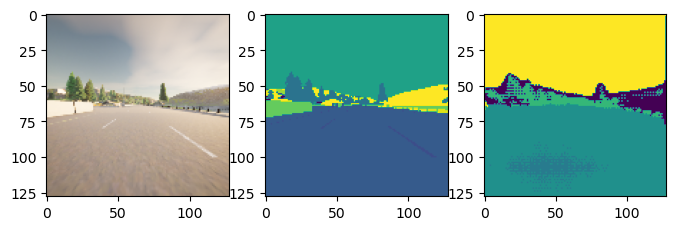

In [45]:
cnt = 0
tarin = train.cache().batch(1)
for image, label in tarin.take(1):
    fig, ax = plt.subplots(1, 3, figsize = (8, 5))
    ax[0].imshow(image[0, :, :, :])
    ax[1].imshow(label[0, :, :, :])
    ax[2].imshow(pred_mask[0, :, :, :])
    
print(cnt)